Cosmology (compact) SS2020

# Exercise 5

## 3. The dependence on cosmological parameters of the abundace of massive objects

Quantify how the various cosmological parameters affect the dark-matter halo mass function from Tinker et al. 2008.

The dark-matter halo mass halo function given by Tinker et al. 2008 is $f(\sigma) = A [(\frac{\sigma}{b})^{-a} + 1] \exp{(-\frac{c}{\sigma^2})}$

$$\frac{dn}{dM}(M,z) = f(\sigma) \frac{\rho_m}{M} \frac{d \ln{[\sigma^{-1}(M,z)]}}{dM}$$

$$\sigma^2(M,z) = \frac{1}{2\pi^2} \int_0^{\infty}{k^2 P_{lin}(k, z) W^2(k, M)dk}$$

In [5]:
import astropy.constants as cst
import scipy.integrate as intg
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u

km_Mpc = (u.km/u.Mpc).to(1)
rho_avg = 1e10

def a(z):
    return 1/(1+z)

def E(z, dict):
    return np.sqrt(dict["Omega_r0"]*(1+z)**4+dict["Omega_m0"]*(1+z)**3+(1-dict["Omega_m0"]-dict["Omega_L0"]-dict["Omega_r0"])*(1+z)**2+dict["Omega_L0"])

# Hubble factor
def H(z, dict):
    return 100*dict["h"]*E(z,dict)    # km/s /Mpc
H_vectorized = np.vectorize(H)

# Density parameters
def Omega_m(z, dict):
    return dict["Omega_m0"]*(1+z)**3/E(z, dict)**2
def rho_m(z, dict):
    rho_crt = ((3*(H(z,dict)*km_Mpc)**2/8/np.pi/cst.G.value)*u.kg/(u.m)**3).to(u.Msun/(u.Mpc)**3)
    return Omega_m(z, dict) * rho_crt.value
def Omega_r(z, dict):
    return dict["Omega_r0"]*(1+z)**4/E(z, dict)**2
def Omega_L(z, dict):
    return dict["Omega_L0"]/E(z, dict)**2
def Omega_K(z, dict):
    Omega_K0 = 1-dict["Omega_m0"]-dict["Omega_L0"]-dict["Omega_r0"]
    return Omega_K0*(1+z)**2/E(z, dict)**2
def Omega_b(z, dict):
    return dict["Omega_b0"]*(1+z)**3/E(z, dict)**2

# Growth Factor
def g(z, dict):
    O_m = Omega_m(z, dict)
    O_L = Omega_L(z, dict)
    return 2.5*O_m/(O_m**(4/7)-O_L+(1+O_m/2)*(1+O_L/70))
def D_growth(z, dict):
    return g(z, dict)/g(0, dict)/(1+z)

# linear power spectrum
n_S = 1
def BBKS(k, dict):     # transfer function, see https://www.researchgate.net/publication/1899507_Evolution_of_density_perturbations_in_decaying_vacuum_cosmology
    O_b = dict["Omega_b0"]
    Sigma = dict["Omega_m0"]*dict["h"]*np.exp(-dict["Omega_b0"] - np.sqrt(2*dict["h"])*dict["Omega_b0"]/dict["Omega_m0"])
    q = k/(Sigma * dict["h"])
    return (np.log(1+2.34*q)/2.34/q)*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-0.25)
def A(dict):
    R8 = 8/dict["h"]   # Mpc
    intgrand = lambda k : (k**2)*(k**n_S)*(BBKS(k, dict)**2)*W_TH(k*R8)
    intgr = intg.quad(intgrand, 0, np.inf)[0]
    return (dict["Sigma8"]**2)*2*(np.pi**2)/intgr
def P(k, z, dict):
    return k**n_S*BBKS(k, dict)**2*D_growth(z, dict)**2*A(dict)
P_vectorized = np.vectorize(P)

# mass variance of the linear density field
def W_G(y):     # Window function, Gaussian; see http://www.astro.yale.edu/vdbosch/astro610_lecture9.pdf
    return np.exp(-(y**2)/2)
def sigma_G(R, z, dict):
    intgrand = lambda k: (k**2)*(W_G(k*R)**2)*(k**n_S)*(BBKS(k, dict)**2)
    res = intg.quad(intgrand, 0, np.inf)[0]
    return 1/(2*np.pi**2) * res * D_growth(z, dict)**2 *A(LCDM)
sigma_G_vectorized = np.vectorize(sigma_G)

def W_TH(y):   # Window function, Top hat
    return 3*(np.sin(y) - y*np.cos(y))/(y**3)
def sigma_TH(M, z, dict):
    R = (M/(4/3 *np.pi * rho_m(z, LCDM)))**(1/3)
    intgrand = lambda k: (W_TH(k*R)**2)*(k**2)*(k**n_S)*(BBKS(k, dict)**2)
    res = intg.quad(intgrand, 0, np.inf)[0]
    return 1/(2*np.pi**2) * res * D_growth(z, dict)**2 *A(LCDM)
sigma_TH_vectorized = np.vectorize(sigma_TH)


# a reference of the variance
# see https://www.slac.stanford.edu/econf/C070730/talks/Wechsler_080207.pdf

In [3]:
LCDM = {"h": 0.67, "Omega_m0": 0.315, "Sigma8":0.829, "Omega_b0":0.02205*0.67**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*0.67**(-2)}

from scipy.misc import derivative

def dndM_T(M, z, dict):
    f_for_d = lambda M1: np.log(1/np.sqrt(sigma_TH(M1, z, LCDM)))
    return f_T(sigma_TH(M, z, dict))*rho_m(z, dict)/M *derivative(f_for_d, M, dx=1e2)
dndM_T_vectorized = np.vectorize(dndM_T)

# see https://watermark.silverchair.com/mnras0402-0191.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAArcwggKzBgkqhkiG9w0BBwagggKkMIICoAIBADCCApkGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMKbrgtEooUHytyxmqAgEQgIICavRyoxJl4HqxW6fH6jqdVNz-tguCjOtYGYL6HU9uUeXDMVQI15YkUaCRyTMuID54BXrfdLNL2NdzKaCTOOFNCLFK54OUQLyuI40N5ckKuHpUdHeKNeEcN66ush1OGEJsJp68wEJ47krSbKZSao2W0bZLOae11UNmVaPV_woIzwGKe2pYJQoCyLmi2rGzqzhJcm2KG9z2ZaycOvwSrTcLT-4S4u6WGs8dtgxNnAP52oafgBaHvds0Uz9Nzw50v7DDkb7TmPd-naKPyxGFcQsoiSQ2YO_GQeiGWOHwyn6fm9PLIot5pPUH8-c9u73W_kzm9Eq4Fvvvt-8M40mfjbieqUFaiwC8vXvvXUzFoLdsM2NDFMx_LfjKZKEXXOrPLNri3mlQ4j8JndKGq88t8v-0nOMQHSvQrMMw8ZIDJKrSiEAlvwgU_46Wx0kdkSZMVzv9AYBVcwUWFxl1wTcVZoSy_fWn3uG2UNtIuFCIegzG6_AJK3-ygUvvB9_HQbiLv1i2FMvZx8P8lUaf6dGfrzoz2gWvbxJepgflXxBJlq0Q29p6ULL5viXvIOolBx3aT8NzQkGilMAiYuveKjNufL4NYjoqcB8bepgg2A0HKTalVejUbOANVvwug9yBVnl70KnLcjvYrPGvxoMeUPOMKypr930ZCWqb6s_QuQ7nHUFXZQoiXXcacMC2QeQMSwomQSxexNGN3ZfDHcIOtGjpuQ4qvNbh_kwj7e24Y3nIXF6xN2xmMC7ZTkN0I9r4la3qSAHLyQh550-rTYk7yTrZqouR014Kj9oxlnwNMjRcm6qKE8tcXCrbLVs2BH0tuw
def f_T(sigma):
    AA, a, b, c = [0.6853, 1.868, 0.3324, 1.2266] # values taken from the paper
    return AA*((sigma/b)**(-a) + 1)*np.exp(-c/sigma**2)
f_T_vectorized = np.vectorize(f_T)

In [13]:
LCDM1 = {"h": 0.67*1.03, "Omega_m0": 0.315, "Sigma8":0.829, "Omega_b0":0.02205*(0.67*1.03)**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*(0.67*1.03)**(-2)}
LCDM2 = {"h": 0.67, "Omega_m0": 0.315, "Sigma8":0.829*1.03, "Omega_b0":0.02205*0.67**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*0.67**(-2)}
LCDM3 = {"h": 0.67, "Omega_m0": 0.315*1.03, "Sigma8":0.829, "Omega_b0":0.02205*0.67**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*0.67**(-2)}
LCDM4 = {"h": 0.67*0.97, "Omega_m0": 0.315, "Sigma8":0.829, "Omega_b0":0.02205*(0.67*0.97)**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*(0.67*0.97)**(-2)}
LCDM5 = {"h": 0.67, "Omega_m0": 0.315, "Sigma8":0.829*0.97, "Omega_b0":0.02205*0.67**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*0.67**(-2)}
LCDM6 = {"h": 0.67, "Omega_m0": 0.315*0.97, "Sigma8":0.829, "Omega_b0":0.02205*0.67**(-2), "Omega_L0": 0.685, "Omega_r0": 2.47*10**(-5)*0.67**(-2)}
x = np.logspace(12, 15.5, 1000)
y0 = dndM_T_vectorized(x, 0, LCDM)
y1 = dndM_T_vectorized(x, 0, LCDM2)
y2 = dndM_T_vectorized(x, 0, LCDM3)
y3 = dndM_T_vectorized(x, 0, LCDM1)
y4 = dndM_T_vectorized(x, 0, LCDM5)
y5 = dndM_T_vectorized(x, 0, LCDM6)
y6 = dndM_T_vectorized(x, 0, LCDM4)

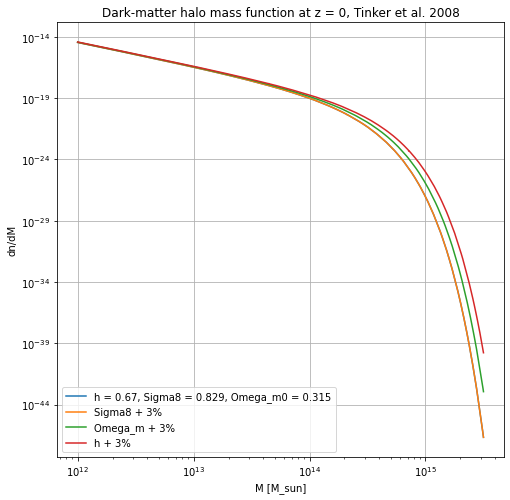

In [14]:
plt.figure(figsize = (8, 8))
plt.plot(x, y0, label = "h = 0.67, Sigma8 = 0.829, Omega_m0 = 0.315")
plt.plot(x, y1, label = "Sigma8 + 3%")
plt.plot(x, y2, label = "Omega_m + 3%")
plt.plot(x, y3, label = "h + 3%")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M [M_sun]")
plt.ylabel("dn/dM")
plt.title("Dark-matter halo mass function at z = 0, Tinker et al. 2008")
plt.legend()
plt.grid()
plt.show()

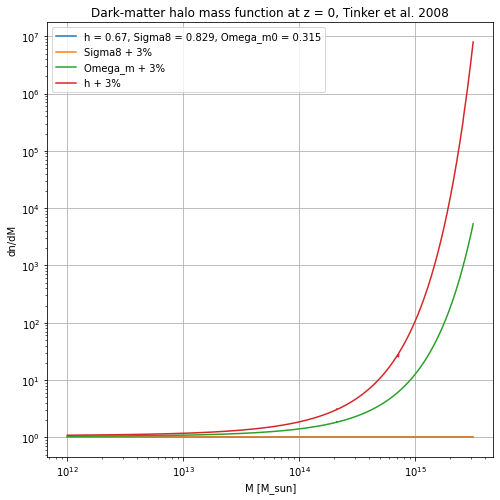

In [23]:
plt.figure(figsize = (8, 8))
plt.plot(x, y0/y0, label = "h = 0.67, Sigma8 = 0.829, Omega_m0 = 0.315")
plt.plot(x, y1/y0, label = "Sigma8 + 3%")
plt.plot(x, y2/y0, label = "Omega_m + 3%")
plt.plot(x, y3/y0, label = "h + 3%")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M [M_sun]")
plt.ylabel("dn/dM")
plt.title("Dark-matter halo mass function at z = 0, Tinker et al. 2008")
plt.legend()
plt.grid()
plt.show()

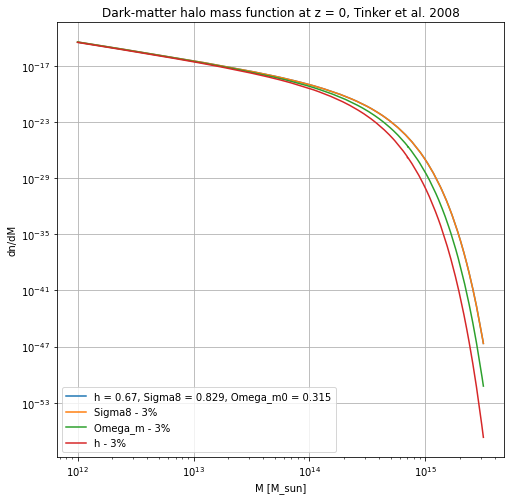

In [18]:
plt.figure(figsize = (8, 8))
plt.plot(x, y0, label = "h = 0.67, Sigma8 = 0.829, Omega_m0 = 0.315")
plt.plot(x, y4, label = "Sigma8 - 3%")
plt.plot(x, y5, label = "Omega_m - 3%")
plt.plot(x, y6, label = "h - 3%")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M [M_sun]")
plt.ylabel("dn/dM")
plt.title("Dark-matter halo mass function at z = 0, Tinker et al. 2008")
plt.legend()
plt.grid()
plt.show()

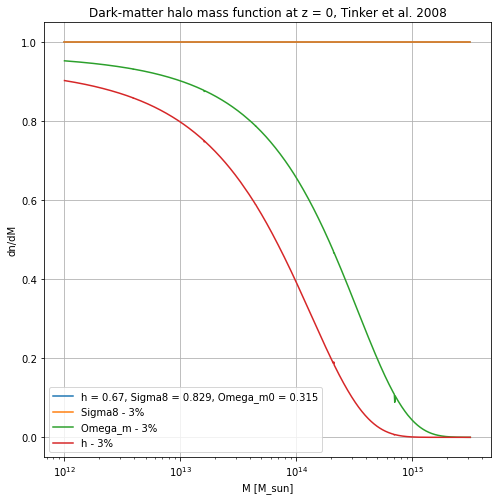

In [20]:
plt.figure(figsize = (8, 8))
plt.plot(x, y0/y0, label = "h = 0.67, Sigma8 = 0.829, Omega_m0 = 0.315")
plt.plot(x, y4/y0, label = "Sigma8 - 3%")
plt.plot(x, y5/y0, label = "Omega_m - 3%")
plt.plot(x, y6/y0, label = "h - 3%")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("M [M_sun]")
plt.ylabel("dn/dM")
plt.title("Dark-matter halo mass function at z = 0, Tinker et al. 2008")
plt.legend()
plt.grid()
plt.show()

From the above plots we see that the halo mass is most sensitve to $h$.

Large mass are particular sensitive to the changes in cosmological parameters. However, that could be due to numerical effects....

In [24]:
y005 = dndM_T_vectorized(x, 0.5, LCDM)
y7 = dndM_T_vectorized(x, 0.5, LCDM1)
y8 = dndM_T_vectorized(x, 0.5, LCDM4)
y01 = dndM_T_vectorized(x, 1, LCDM)
y9 = dndM_T_vectorized(x, 1, LCDM1)
y10 = dndM_T_vectorized(x, 1, LCDM4)
y015 = dndM_T_vectorized(x, 1.5, LCDM)
y11 = dndM_T_vectorized(x, 1.5, LCDM1)
y12 = dndM_T_vectorized(x, 1.5, LCDM4)

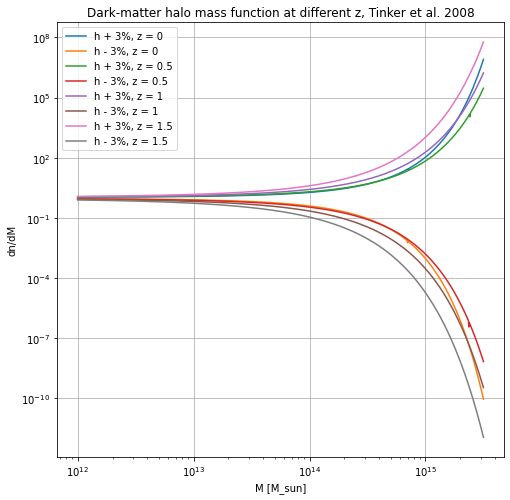

In [26]:
plt.figure(figsize = (8, 8))
plt.plot(x, y3/y0, label = "h + 3%, z = 0")
plt.plot(x, y6/y0, label = "h - 3%, z = 0")
plt.plot(x, y7/y005, label = "h + 3%, z = 0.5")
plt.plot(x, y8/y005, label = "h - 3%, z = 0.5")
plt.plot(x, y9/y01, label = "h + 3%, z = 1")
plt.plot(x, y10/y01, label = "h - 3%, z = 1")
plt.plot(x, y11/y015, label = "h + 3%, z = 1.5")
plt.plot(x, y12/y015, label = "h - 3%, z = 1.5")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M [M_sun]")
plt.ylabel("dn/dM")
plt.title("Dark-matter halo mass function at different z, Tinker et al. 2008")
plt.legend()
plt.grid()
plt.show()

From the above plot we see the deviation is larger at larger redshift, thus high-redshift haloes are more sensitive to variations in the parameter.